In [430]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import sys

sys.path.append(os.path.abspath("../../"))
from dataset import DS_NAMES
from dataset import DS_DIMENSIONS
from utilities.figure_tools import get_latest_results_directory, make_fig_directory, load_results

cmap = plt.get_cmap("Set1")
colors = cmap.colors

In [431]:
run_id, run_path = get_latest_results_directory("../../results/compare-methods/")
# run_id = 94
# run_path = "C:/Users/Peter/Documents/Peter/9-Graduate-School/2-dsrg/explainable-ad/code/HEEAD/results/compare-methods/run-094"
fig_output_path = make_fig_directory(run_id)
found_ds, results = load_results(run_path, group_field="explainer")

all_results = pd.DataFrame(columns=["dataset", "explainer", "n_samples", "n_features", "accuracy", "precision",
                               "recall", "f1", "avg_nnodes", "avg_nleaves", "avg_depth", "q", "jaccard", "coverage_ratio", "mean_distance", "mean_length", "runtime", "sample_runtime", "mdr"])

for ds in found_ds:
    results[ds]["sample_runtime"] = results[ds].runtime / (results[ds].n_samples * 0.2) * 1000 # / 20 * 1000
    results[ds]["mdr"] = results[ds].mean_distance / np.sqrt(results[ds].n_features) * 100

for ds in found_ds:
    for index, row in results[ds].iterrows():
        row["dataset"] = ds
        all_results = all_results.append(row)

found_explainers = all_results["explainer"].unique()
explainer_dict = {
    "BestCandidate" : "AFT",
    "GraphMerge" : "FACET",
    "OCEAN" : "OCEAN",
    "MACE": "MACE"
}
explainer_colors = {
    "BestCandidate" : colors[3] , # purple
    "GraphMerge" : colors[0], # red
    "OCEAN" : colors[4], # orange
    "MACE": colors[1] # blue
}
explainer_names = []
for e in found_explainers:
    explainer_names.append(explainer_dict[e])

print("Generating figures for run-{:03d}".format(run_id))
print("Datasets included:")
for ds in found_ds:
    print("\t", ds)
print("Explainers included:")
for expl in found_explainers:
    print("\t", expl)

Generating figures for run-001
Datasets included:
	 annthyroid
	 cardio
	 musk
	 pendigits
	 satimage
	 shuttle
	 thyroid
	 wbc
Explainers included:
	 BestCandidate
	 GraphMerge


In [432]:
all_results.head()

,dataset,explainer,n_samples,n_features,accuracy,precision,recall,f1,avg_nnodes,avg_nleaves,avg_depth,q,jaccard,coverage_ratio,mean_distance,mean_length,runtime,sample_runtime,mdr,n_samples_explained
0,annthyroid,BestCandidate,7200,6,0.982500,0.829843,0.962553,0.890158,30.42,15.710,5.00,0.951621,0.851325,1.000000,0.019724,1.483819,4.222264,2.932128,0.805237,1440.0
1,annthyroid,GraphMerge,7200,6,0.982500,0.829843,0.962553,0.890158,30.42,15.710,5.00,0.951621,0.851325,0.553958,0.011017,1.267050,1.142189,0.793187,0.449757,1440.0
0,cardio,BestCandidate,1831,21,0.982016,0.951745,0.859801,0.902667,27.08,14.040,5.00,0.867508,0.382115,0.832425,0.341937,1.470745,0.993854,2.713965,7.461686,367.0
1,cardio,GraphMerge,1831,21,0.982016,0.951745,0.859801,0.902667,27.08,14.040,5.00,0.867508,0.382115,0.029973,0.088344,1.138512,1.023835,2.795836,1.927830,367.0
0,musk,BestCandidate,3062,166,1.000000,1.000000,1.000000,1.000000,3.51,2.255,1.23,0.000000,0.042856,0.000000,NaN,NaN,0.864304,1.411339,NaN,613.0


In [433]:
def render_bar_plot(xfeature, yfeature, xlabel, ylabel, title, save_name=None, xrange=None, yrange=None, xlog=False, lloc=None):
    fig, ax = plt.subplots()
    pos = np.arange(len(found_ds))
    bar_width = 0.15

    yvalues = all_results[yfeature].unique()

    for i in range(len(yvalues)):
        isExpl = all_results[yfeature] == yvalues[i]
        hbars = ax.barh(y=(pos + bar_width*i), width=all_results[isExpl][xfeature], height=bar_width, log=xlog, color=explainer_colors[yvalues[i]])
        print(yfeature)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    if not lloc:
        lloc = "best"
    plt.legend(explainer_names, loc=lloc)
    plt.yticks(pos, found_ds)

    if save_name is not None:
        plt.savefig(fig_output_path + "/" + save_name)

explainer
explainer


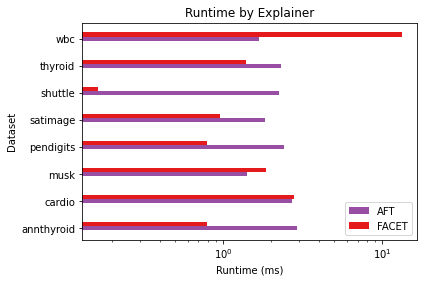

In [434]:
render_bar_plot("sample_runtime", "explainer", "Runtime (ms)", "Dataset", "Runtime by Explainer", "runtime.png", xlog=True)

explainer
explainer


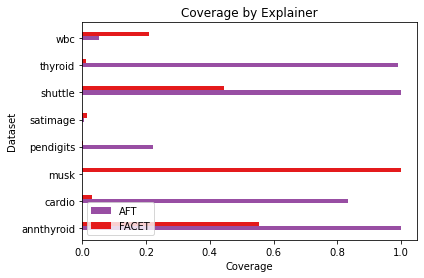

In [435]:
render_bar_plot("coverage_ratio", "explainer", "Coverage", "Dataset", "Coverage by Explainer", "coverage.png", lloc="lower left")

explainer
explainer


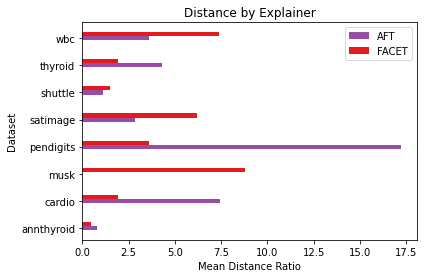

In [436]:
render_bar_plot("mdr", "explainer", "Mean Distance Ratio", "Dataset", "Distance by Explainer", "distance.png")

explainer
explainer


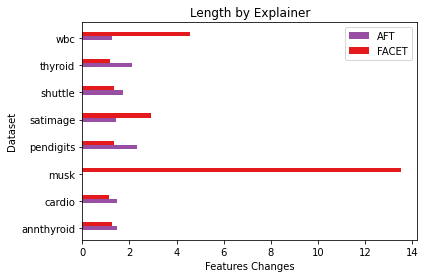

In [437]:
render_bar_plot("mean_length", "explainer", "Features Changes", "Dataset", "Length by Explainer", "length.png")

In [438]:
# Classification performance

md_table_path = fig_output_path + "/results.md"
f = open(md_table_path, "w")

metrics = ["f1", "avg_nnodes", "avg_nleaves", "avg_depth", "q", "jaccard"]
formats = ["{v:0.2f}", "{v:0.2f}", "{v:0.2f}", "{v:0.2f}", "{v:0.2f}", "{v:0.2f}"]

f.write("| dataset | n | p | f1 | nNodes | nLeaves | depth | Q | J |\n")
f.write("|---------|---|---|----|--------|---------|-------|---|---|\n")

for ds in found_ds:
    n = DS_DIMENSIONS[ds][0]
    p = DS_DIMENSIONS[ds][1]
    f.write("| {ds} | {n} | {p}".format(ds=ds, n=n, p=p))
    for i in range(len(metrics)):
        metric = metrics[i]
        isexpl = results[found_ds[0]]["explainer"] == found_explainers[0]
        val = results[ds][isexpl][metric].to_numpy()[0]
        f.write((" | " + "{v:0.2f}" + "").format(v=val))
    f.write(" |")
    f.write("\n")

# Explanation performance
f.write("\n\n")
metrics = ["coverage_ratio", "sample_runtime", "mean_length", "mdr"]
scales = [100, 1, 1, 1]
f.write("|            |       |     | AFT    | FACET  | AFT   | FACET | AFT   | FACET | AFT   | FACET  |\n")
f.write("| ---------- | ----- | --- | ------ | ------ | ----- | ----- | ----- | ----- | ----- | ------ |\n")
f.write("| Dataset    | n     | p   | C      | C      | R     | R     | L     | L     | D     | D      |\n")

for ds in found_ds:
    n = DS_DIMENSIONS[ds][0]
    p = DS_DIMENSIONS[ds][1]
    f.write("| {ds} | {n} | {p}".format(ds=ds, n=n, p=p))
    for i in range(len(metrics)):
        metric = metrics[i]
        scale = scales[i]
        for explainer in found_explainers:
            isexpl = results[found_ds[0]]["explainer"] == explainer
            val = results[ds][isexpl][metric].to_numpy()[0]
            f.write(" | {v:0.2f}".format(v=val * scale))
    f.write(" |")
    f.write("\n")

f.close()